## purpose of this notebook

- given a single time step or series of timesteps, return simply the G term as a 3D map to see where these things are happening
- this will mean us using the terms we had before (can probably add a conditional to the existing function)

In [69]:
# load the packages and functions

# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from adv_closure_TS import *

In [71]:
# set the correct directories based on official ASTE
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirdiags = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/BUDG/"
dirstate = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/STATE/"

# layers path here is for what time steps?
layers_path2007 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
layers_path2016 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000736272_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"


In [72]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

# load the indices from file
data = np.load("/home/mmurakami/crios_backups/an_helper_functions/gates_BSO.npz")

y_bsoh, x_bsoh = data["y_bsoh"], data["x_bsoh"]
y_bsov, x_bsov = data["y_bsov"], data["x_bsov"]

y_fjnzv, x_fjnzv = data["y_fjnzv"], data["x_fjnzv"]
y_fjnz,  x_fjnz  = data["y_fjnz"],  data["x_fjnz"]

y_nzruv, x_nzruv = data["y_nzruv"], data["x_nzruv"]

y_spfjh, x_spfjh = data["y_spfjh"], data["x_spfjh"]
y_spfjv, x_spfjv = data["y_spfjv"], data["x_spfjv"]
y_spfjb, x_spfjb = data["y_spfjb"], data["x_spfjb"]

print("keys:", list(data.keys()))


# 01.22.26: define another gateway midpoint, need to include this in gate functions and add a flag to the gates_check function

keys: ['y_bsoh', 'x_bsoh', 'y_bsov', 'x_bsov', 'y_fjnzv', 'x_fjnzv', 'y_fjnz', 'x_fjnz', 'y_nzruv', 'x_nzruv', 'y_spfjh', 'x_spfjh', 'y_spfjv', 'x_spfjv', 'y_spfjb', 'x_spfjb']


In [73]:
# let's move the gate calculation to a function to show a timeseries
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

In [74]:
# also load the bins again so we have them locally
## load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

## for some example year or timeseries, get the values

In [75]:
# let's move the gate calculation to a function to show a timeseries
# define tstep

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
# times['2007'] = np.arange(1,5,1)  # two timesteps only, cool this works, now plot all
# times['2008'] = np.array([1])
times['2007'] = np.arange(1,13,1)
times['2008'] = np.array([1])

# the filenames we want for 2014
tsstrfull,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstrfull

array(['0000262944', '0000267408', '0000271440', '0000275904',
       '0000280224', '0000284688', '0000289008', '0000293472',
       '0000297936', '0000302256', '0000306720', '0000311040',
       '0000315504'], dtype='<U32')

In [76]:
# one time step for 2007 and 2016
# make an array to save all the timesteps (or a dict)
out = {}

for ts in tsstrfull[1:]:
    out[ts] = {}
    out[ts]["Tbudg"] = {}
    out[ts]["Sbudg"] = {}
    out[ts]["GT"] = {}  # contains ADVh, ADVr, DFh, DFr, surf, kpp, tend
    out[ts]["GS"] = {}
    out[ts]["gatesT"] = {}
    out[ts]["gatesS"] = {}

In [77]:
# great this is still working, now use create_layersSALT and create_layersTHETA to return the terms

# not sure yet if it's better to return dfHx and dfHy separately - we can plot an example to see
# we can also return these separately

In [78]:
times = {}
times['2007'] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

array(['0000262944', '0000267408'], dtype='<U32')

# we can also make a trend/climatology of these for 2006--2017 and thus create a climatology

In [79]:

def save_jfm_mean_maps_under_first_ts_pairfunc(
    tsstr, *,
    mygrid, myparms, dirdiags, dirState, layers_path, mymsk,
    nz, ny, nx, nfx, nfy,
    dt=None,  # if you pass dt per month externally, provide it; otherwise we’ll compute from datetimes if given
    datetimes=None,  # optional: list aligned with tsstr for per-month dt
    mapping=True,
    out=None,
    keys=("ADVh", "ADVr", "DFh", "DFr", "surf", "kpp", "tend"),
):
    """
    create_layersTHETA/SALT require a *pair* of timesteps [ts0, ts1] to form a monthly mean budget.
    Given a list of month-start timesteps for a year (e.g. Jan..Apr to make Jan..Mar means),
    this forms pairs: (ts[0],ts[1]), (ts[1],ts[2]), ... and averages the resulting monthly maps.

    For JFM you typically want tsstr containing 4 month-start timesteps: Jan, Feb, Mar, Apr
    so you can form 3 monthly means: Jan=[Jan,Feb], Feb=[Feb,Mar], Mar=[Mar,Apr].

    Saves the mean over those 3 monthly maps under out[key] where key = tsstr[0].
    """
    if out is None:
        out = {}

    tsstr = list(tsstr)
    if len(tsstr) < 2:
        raise ValueError("Need at least 2 timesteps to form one pair [ts0,ts1].")

    # number of month-means we can form
    npairs = len(tsstr) - 1

    # accumulate sums
    GT_sum = {k: None for k in keys}
    GS_sum = {k: None for k in keys}

    for i in range(npairs):
        pair = np.array([tsstr[i], tsstr[i + 1]])

        # dt handling:
        # - if dt is given as a scalar: use it
        # - elif datetimes is given: use (dt[i+1]-dt[i]) seconds
        # - else: dt is required
        if dt is None:
            if datetimes is None:
                raise ValueError("Provide either dt (scalar) or datetimes (aligned with tsstr) to compute dt per pair.")
            dt_pair = (datetimes[i + 1] - datetimes[i]).total_seconds()
        else:
            dt_pair = dt

        # THETA monthly map from pair
        ADVhT, ADVrT, DFhT, DFrT, Ft_surfT, kppT, tendT = create_layersTHETA(
            pair, mygrid, myparms, dirdiags, dirState,
            layers_path, mymsk,
            nz, ny, nx, nfx, nfy, dt_pair,
            mapping=mapping
        )
        GT_this = {
            "ADVh": ADVhT, "ADVr": ADVrT, "DFh": DFhT, "DFr": DFrT,
            "surf": Ft_surfT, "kpp": kppT, "tend": tendT
        }

        # SALT monthly map from pair
        ADVhS, ADVrS, DFhS, DFrS, Ft_surfS, kppS, tendS = create_layersSALT(
            pair, mygrid, myparms, dirdiags, dirState,
            layers_path, mymsk,
            nz, ny, nx, nfx, nfy, dt_pair,
            mapping=mapping
        )
        GS_this = {
            "ADVh": ADVhS, "ADVr": ADVrS, "DFh": DFhS, "DFr": DFrS,
            "surf": Ft_surfS, "kpp": kppS, "tend": tendS
        }

        # accumulate
        for k in keys:
            aT = np.asarray(GT_this[k], dtype=np.float64)
            aS = np.asarray(GS_this[k], dtype=np.float64)
            GT_sum[k] = aT if GT_sum[k] is None else (GT_sum[k] + aT)
            GS_sum[k] = aS if GS_sum[k] is None else (GS_sum[k] + aS)

    # mean across the npairs monthly maps
    GT_mean = {k: GT_sum[k] / float(npairs) for k in keys}
    GS_mean = {k: GS_sum[k] / float(npairs) for k in keys}

    key = tsstr[0]
    out[key] = {
        "GT": GT_mean,
        "GS": GS_mean,
        "meta": {
            "ts_list": tsstr,
            "pairs": [(tsstr[i], tsstr[i + 1]) for i in range(npairs)],
            "npairs": npairs,
            "note": "Mean of monthly maps from consecutive timestep pairs."
        }
    }
    return out


# -------------------------
# Example usage: JFM mean maps for 2007
# Need Jan..Apr timesteps to form Jan,Feb,Mar monthly means.
# -------------------------
times = {"2007": np.arange(1, 4)}  # Jan, Feb, Mar, Apr
tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

out = save_jfm_mean_maps_under_first_ts_pairfunc(
    tsstr,
    datetimes=datetimes,   # lets us compute dt per pair correctly
    dt=None,               # leave None to use datetimes diffs
    mygrid=mygrid, myparms=myparms, dirdiags=dirdiags, dirState=dirState,
    layers_path=layers_path, mymsk=mymsk,
    nz=nz, ny=ny, nx=nx, nfx=nfx, nfy=nfy,
    mapping=True,
    out=None
)

times = {"2016": np.arange(1, 4)}  # Jan, Feb, Mar, Apr
tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

out16 = save_jfm_mean_maps_under_first_ts_pairfunc(
    tsstr,
    datetimes=datetimes,   # lets us compute dt per pair correctly
    dt=None,               # leave None to use datetimes diffs
    mygrid=mygrid, myparms=myparms, dirdiags=dirdiags, dirState=dirState,
    layers_path=layers_path, mymsk=mymsk,
    nz=nz, ny=ny, nx=nx, nfx=nfx, nfy=nfy,
    mapping=True,
    out=None
)

In [80]:
from scipy.ndimage import binary_dilation

def jfm_mean_SI_masked(
    tsstr, *,  # expects month timesteps; for JFM mean use Jan..Apr so you can form Jan,Feb,Mar month-means
    dirState, ny, nx, nfx, nfy,
    landmsk, mymsk,
    file_name="state_2d_set1",
    varname="SIarea",
    land_buffer_iters=1,
):
    """
    Returns:
      SI_masked_mean_tr : (tile) 2D on tracer grid (get_aste_tracer(...)[0]) AFTER land-buffer masking,
                          averaged over JFM monthly means.
      SI_mean_tr        : same but without land-buffer masking
      meta              : dict with used pairs and timesteps

    Convention:
      Each monthly mean uses the *second* timestep in the pair (matches your read=[int(tsstr[1])] pattern).
      JFM mean is the average of the 3 monthly fields from pairs:
        Jan=[ts0,ts1], Feb=[ts1,ts2], Mar=[ts2,ts3]
      So you should pass tsstr = [Jan, Feb, Mar, Apr] (length 4).
    """
    tsstr = list(tsstr)
    if len(tsstr) < 2:
        raise ValueError("Need at least 2 timesteps to form one monthly field.")
    npairs = len(tsstr) - 1
    if npairs < 1:
        raise ValueError("Need at least one pair.")

    # --- parse meta once to find record index ---
    meta_state_2d = parsemeta(os.path.join(dirState, f"{file_name}.{tsstr[0]}.meta"))
    fldlist = np.array(meta_state_2d["fldList"])
    idx = np.where(fldlist == varname)[0]
    if len(idx) == 0:
        raise KeyError(f"{varname} not in fldList. Available: {list(fldlist)}")
    rec = int(idx[0])

    # --- land buffer mask on tracer grid (constant across time) ---
    landmask_tr = (get_aste_tracer(landmsk, nfx, nfy)[0] > 0)
    landbuffer_tr = binary_dilation(landmask_tr, iterations=land_buffer_iters)

    # --- loop month-pairs and accumulate on tracer grid ---
    acc_tr = None
    acc_masked_tr = None

    pairs = []
    for i in range(npairs):
        pairs.append((tsstr[i], tsstr[i + 1]))

        # match your convention: use the second timestep of the pair
        read = [int(tsstr[i + 1])]
        SIarea_frac, its, meta = rdmds(
            os.path.join(dirState, file_name),
            read,
            returnmeta=True,
            rec=rec
        )  # m^2/m^2
        SIarea = np.asarray(SIarea_frac).reshape((ny, nx))

        # map to tracer-tile (your plotting face)
        SI_tr = get_aste_tracer(SIarea, nfx, nfy)[0]

        # apply land-buffer mask
        SI_masked = np.where(landbuffer_tr, np.nan, SI_tr)

        if acc_tr is None:
            acc_tr = np.zeros_like(SI_tr, dtype=np.float64)
            acc_masked_tr = np.zeros_like(SI_tr, dtype=np.float64)
            cnt_tr = np.zeros_like(SI_tr, dtype=np.float64)
            cnt_masked = np.zeros_like(SI_tr, dtype=np.float64)

        # nan-safe accumulate (mean over time)
        ok = np.isfinite(SI_tr)
        acc_tr[ok] += SI_tr[ok]
        cnt_tr[ok] += 1.0

        okm = np.isfinite(SI_masked)
        acc_masked_tr[okm] += SI_masked[okm]
        cnt_masked[okm] += 1.0

    SI_mean_tr = acc_tr / np.where(cnt_tr > 0, cnt_tr, np.nan)
    SI_masked_mean_tr = acc_masked_tr / np.where(cnt_masked > 0, cnt_masked, np.nan)

    meta_out = {"ts_list": tsstr, "pairs": pairs, "npairs": npairs, "read_second_of_pair": True}
    return SI_masked_mean_tr, SI_mean_tr, meta_out


# -------------------------
# Example: JFM mean SI for 2007
# (need Jan..Apr timesteps so you can form 3 monthly fields)
# -------------------------
times = {"2007": np.arange(1, 4)}  # Jan, Feb, Mar, Apr
tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

SI_masked_JFM, SI_JFM, metaSI = jfm_mean_SI_masked(
    tsstr,
    dirState=dirState, ny=ny, nx=nx, nfx=nfx, nfy=nfy,
    landmsk=landmsk, mymsk=mymsk,  # mymsk not used here except you might want it later
    land_buffer_iters=1,
)

times16 = {"2016": np.arange(1, 4)}  # Jan, Feb, Mar, Apr
tsstr16, datetimes16 = get_tsteps(times16, fnames, dt_aste, startyr, 1, 1)

SI_masked_JFM16, SI_JFM16, metaSI16 = jfm_mean_SI_masked(
    tsstr16,
    dirState=dirState, ny=ny, nx=nx, nfx=nfx, nfy=nfy,
    landmsk=landmsk, mymsk=mymsk,  # mymsk not used here except you might want it later
    land_buffer_iters=1,
)

In [81]:
depth_lev = np.cumsum(mygrid['DRF']) # this is the depth cutoffs we can have

des = 100  # desired depth level
des = 1000
depths = np.where(depth_lev <= des)
depths = depths[0]

In [47]:
des = 300  # desired max depth (m)

depths = np.where((depth_lev >= 100) & (depth_lev <= des))[0]

In [82]:
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

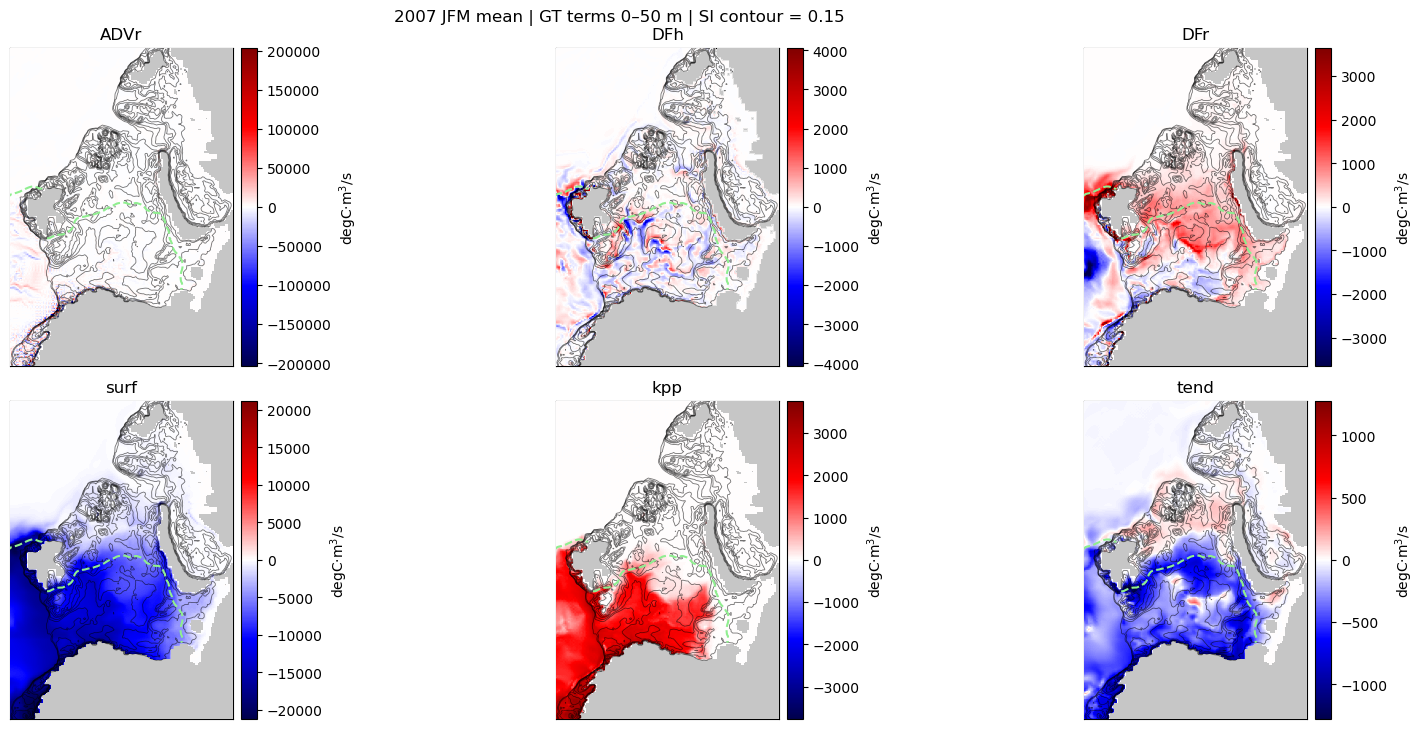

In [61]:
# -------- inputs you already have --------
# out: dict
# ts0 = tsstr[0]   (key you saved under)
# SI_masked_JFM: 2D array on same tile as get_aste_tracer(...)[0]
# nfx, nfy: aste face dims

ts0 = tsstr[0]
dt0 = datetimes[0]  # label only

# terms to plot (we may drop "surf" depending on depth range)
terms = ["ADVh", "ADVr", "DFh", "DFr", "surf", "kpp", "tend"]

land_data  = get_aste_tracer(landmsk, nfx, nfy)[0]
depth_data = get_aste_tracer(mygrid["Depth"], nfx, nfy)[0]
msk_tr     = get_aste_tracer(mymsk,  nfx, nfy)[0]

# thin depth contours
depth_levels = [50, 100, 150, 200, 300, 400, 500]
depth_contour_kw = dict(colors="k", linewidths=0.6, alpha=0.55, zorder=9)

SI_to_contour = SI_masked_JFM

# ---------------------------------------
# if depth selection is entirely deeper than 50 m, do not plot "surf"
# (i.e., if the shallowest selected depth >= 50 m)
# ---------------------------------------
startdep = float(depth_lev[np.asarray(depths)[0]])
if startdep >= 50:
    plot_terms = [t for t in terms if t != "surf"]
else:
    plot_terms = terms

# we plot panels for ADVr..tend (skip ADVh), but now based on plot_terms
panel_terms = plot_terms[1:]  # skip ADVh

# choose layout automatically: 6 terms -> 2x3, 5 terms -> 2x3 with one blank, etc.
n_panels = len(panel_terms)
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(axes)

for i, name in enumerate(panel_terms):
    ax = axes[i]

    A3 = out[ts0]["GT"][name]                 # (nz, ny, nx) or (ny, nx) for surf
    if name == "surf":
        # surf is 2D; no depth averaging
        A2d = np.asarray(A3, dtype=float)
    else:
        A2d = np.nanmean(np.asarray(A3, dtype=float)[depths], axis=0)

    A_tr = get_aste_tracer(A2d, nfx, nfy)[0]

    # symmetric normalization about 0
    masked = A_tr * np.where(np.isfinite(msk_tr), msk_tr, 0.0)
    vmax = np.nanmax(np.abs(masked))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    # base layers
    ax.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)
    ax.pcolormesh(depth_data, cmap="Greys_r", alpha=0.10, vmin=100, vmax=600, zorder=2)

    # main field
    im = ax.imshow(A_tr, origin="lower", cmap="seismic", norm=norm, zorder=3)

    # depth contours
    ax.contour(depth_data, levels=depth_levels, **depth_contour_kw)

    # SI contour
    ax.contour(
        SI_to_contour,
        levels=[0.15],
        colors="lightgreen",
        linewidths=1.5,
        linestyles="--",
        zorder=10,
    )

    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(400, 540)
    ax.set_ylim(400, 600)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02, label="degC·m$^3$/s")

# hide unused axes
for j in range(n_panels, nrows * ncols):
    axes[j].axis("off")

# depth string
if startdep == 10:
    startdep = 0
enddep = float(depth_lev[np.asarray(depths)[-1]])
depthstr = f"{int(startdep)}–{int(enddep)} m"

year_str = dt0.strftime("%Y")
fig.suptitle(f"{year_str} JFM mean | GT terms {depthstr} | SI contour = 0.15", y=1.02)

plt.show()


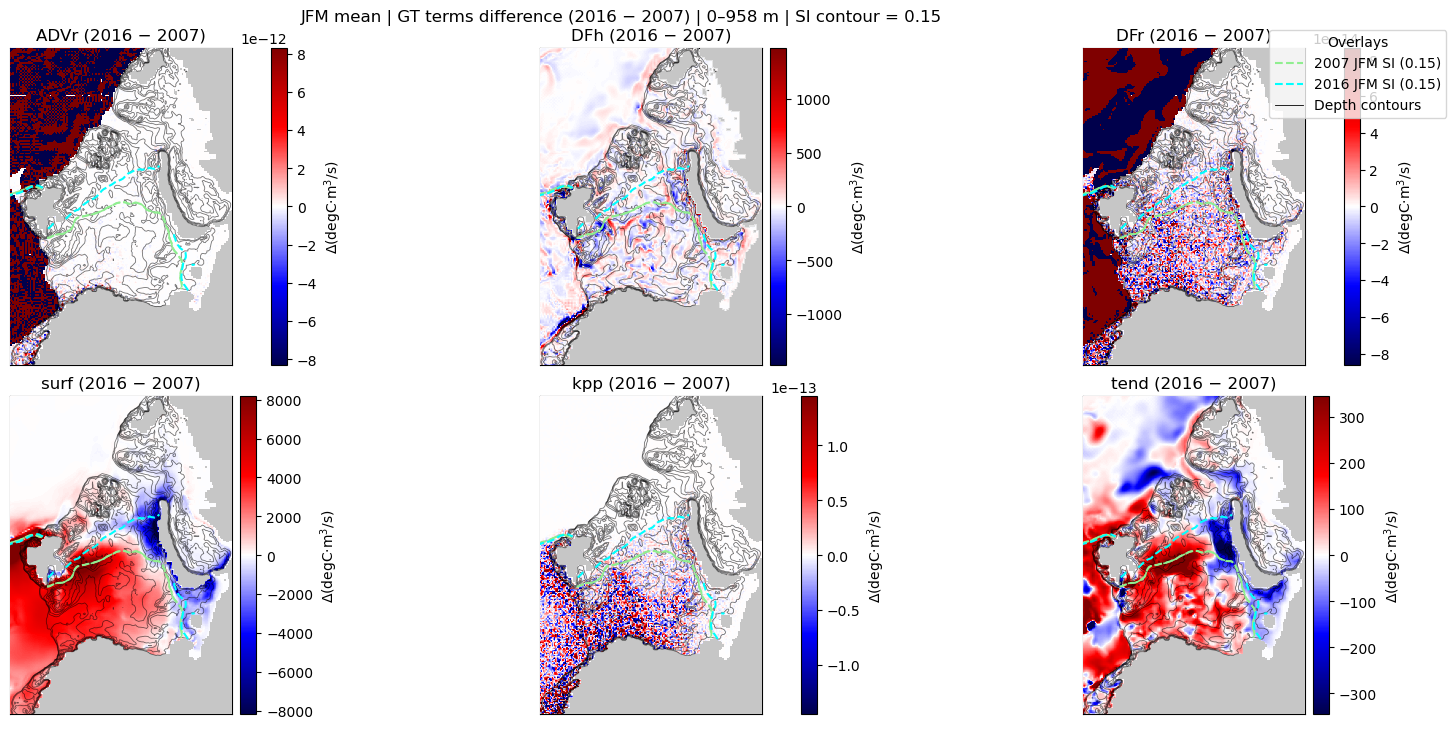

In [84]:

# ------------------------------------------------------------
# inputs you said you have
#   out07: (or `out` for 2007 JFM mean) dict keyed by ts0 (first JFM ts)
#   out16: dict keyed by ts0_16 (first JFM ts)
#   SI_masked_JFM16: JFM-mean SI mask for 2016 on tracer tile
#   SI_masked_JFM07: JFM-mean SI mask for 2007 on tracer tile (you need this too)
# ------------------------------------------------------------

# pick the keys (first JFM timestep strings)
ts0_07 = list(out.keys())[0]     # if `out` is your 2007 JFM-mean dict
ts0_16 = list(out16.keys())[0]   # 2016 JFM-mean dict

# choose which SI to contour on the DIFFERENCE plot:
# option A: contour 2016 ice edge
SI_to_contour = SI_masked_JFM16
# option B: contour both years (uncomment):
SI_to_contour_07 = SI_masked_JFM
SI_to_contour_16 = SI_masked_JFM16

# ------------------------------------------------------------
# shared plot config (same style as your single-year plot)
# ------------------------------------------------------------
terms = ["ADVh", "ADVr", "DFh", "DFr", "surf", "kpp", "tend"]

land_data  = get_aste_tracer(landmsk, nfx, nfy)[0]
depth_data = get_aste_tracer(mygrid["Depth"], nfx, nfy)[0]
msk_tr     = get_aste_tracer(mymsk,  nfx, nfy)[0]

depth_levels = [50, 100, 150, 200, 300, 400, 500]
depth_contour_kw = dict(colors="k", linewidths=0.6, alpha=0.55, zorder=9)

# drop surf if all selected depths are >= 50 m
startdep = float(depth_lev[np.asarray(depths)[0]])
if startdep >= 50:
    plot_terms = [t for t in terms if t != "surf"]
else:
    plot_terms = terms

panel_terms = plot_terms[1:]  # skip ADVh

# ------------------------------------------------------------
# compute + plot 2016 - 2007
# ------------------------------------------------------------
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(axes)

for i, name in enumerate(panel_terms):
    ax = axes[i]

    A3_07 = out[ts0_07]["GT"][name]
    A3_16 = out16[ts0_16]["GT"][name]

    if name == "surf":
        A2d_07 = np.asarray(A3_07, dtype=float)
        A2d_16 = np.asarray(A3_16, dtype=float)
    else:
        A2d_07 = np.nanmean(np.asarray(A3_07, dtype=float)[depths], axis=0)
        A2d_16 = np.nanmean(np.asarray(A3_16, dtype=float)[depths], axis=0)

    # difference in ASTE layout, then map to tile
    dA2d = A2d_16 - A2d_07
    dA_tr = get_aste_tracer(dA2d, nfx, nfy)[0]

    # symmetric norm about 0
    masked = dA_tr * np.where(np.isfinite(msk_tr), msk_tr, 0.0)
    vmax = np.nanmax(np.abs(masked)) /2
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    # base layers
    ax.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)
    ax.pcolormesh(depth_data, cmap="Greys_r", alpha=0.10, vmin=100, vmax=600, zorder=2)

    # main field: 2016 - 2007
    im = ax.imshow(dA_tr, origin="lower", cmap="seismic", norm=norm, zorder=3)

    # depth contours
    ax.contour(depth_data, levels=depth_levels, **depth_contour_kw)

    # SI contour(s)
    ax.contour(
        SI_to_contour_07,
        levels=[0.15],
        colors="lightgreen",
        linewidths=1.5,
        linestyles="--",
        zorder=10,
        label="2007 JFM SI"
    )
    # optional: contour 2007 too
    ax.contour(SI_to_contour_07, levels=[0.15], colors="lightgreen", linewidths=1.2, linestyles="--", zorder=10)
    ax.contour(SI_to_contour_16, levels=[0.15], colors="cyan", linewidths=1.5, linestyles="--", zorder=10,label="2016 JFM SI")

    ax.set_title(f"{name} (2016 − 2007)")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(400, 540)
    ax.set_ylim(400, 600)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02, label="Δ(degC·m$^3$/s)")

# hide unused
for j in range(len(panel_terms), nrows * ncols):
    axes[j].axis("off")

# title
if startdep == 10:
    startdep = 0
enddep = float(depth_lev[np.asarray(depths)[-1]])
depthstr = f"{int(startdep)}–{int(enddep)} m"
# plt.legend()


# --- proxy artists for legend ---
legend_handles = [
    Line2D([0], [0], color="lightgreen", lw=1.5, ls="--", label="2007 JFM SI (0.15)"),
    Line2D([0], [0], color="cyan",       lw=1.5, ls="--", label="2016 JFM SI (0.15)"),
    Line2D([0], [0], color="k",          lw=0.6, ls="-",  label="Depth contours"),
]

# place legend for whole figure (recommended for multi-panel)
fig.legend(
    handles=legend_handles,
    loc="upper right",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
    title="Overlays"
)

fig.suptitle(f"JFM mean | GT terms difference (2016 − 2007) | {depthstr} | SI contour = 0.15", y=1.02)
plt.show()

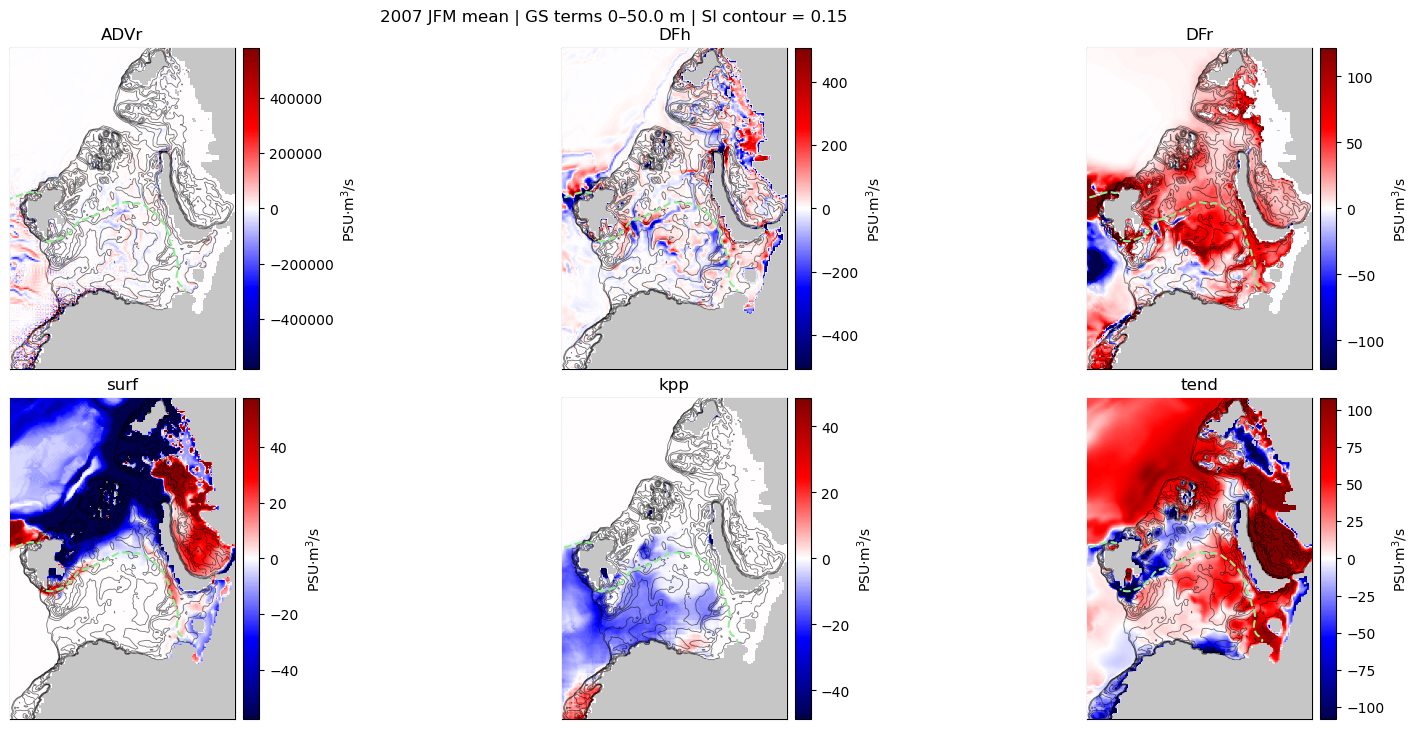

In [24]:
# -------- inputs you already have --------
# out: dict
# ts0 = tsstr[0]   (key you saved under)
# SI_masked_JFM: 2D array on same tile as get_aste_tracer(...)[0]   <-- use JFM mean mask
# nfx, nfy: aste face dims

ts0 = tsstr[0]
dt0 = datetimes[0]  # for labeling

terms = ["ADVh", "ADVr", "DFh", "DFr", "surf", "kpp", "tend"]

land_data  = get_aste_tracer(landmsk, nfx, nfy)[0]
depth_data = get_aste_tracer(mygrid["Depth"], nfx, nfy)[0]

# thin depth contours
depth_levels = [50, 100, 150, 200, 300, 400, 500]
depth_contour_kw = dict(colors="k", linewidths=0.6, alpha=0.55, zorder=9)

# choose which SI field to contour (JFM mean)
SI_to_contour = SI_masked_JFM

# 2x3 grid for ADVr..tend
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(axes)

for i, name in enumerate(terms[1:]):  # skip ADVh
    ax = axes[i]

    # depth-avg of the 3D map, then to tile
    A3  = out[ts0]["GS"][name]                 # (nz, ny, nx)
    A2d = np.nanmean(A3[depths], axis=0)       # (ny, nx)
    A_tr = get_aste_tracer(A2d, nfx, nfy)[0]   # tile

    # symmetric normalization about 0 (centered at 0)
    vmax = np.nanmax(np.abs(A_tr * get_aste_tracer(mymsk,nfx,nfy)[0]))/2
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    # base layers
    ax.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)
    ax.pcolormesh(depth_data, cmap="Greys_r", alpha=0.10, vmin=100, vmax=600, zorder=2)

    # main field
    im = ax.imshow(A_tr, origin="lower", cmap="seismic", norm=norm, zorder=3)

    # depth contours (thin)
    ax.contour(depth_data, levels=depth_levels, **depth_contour_kw)

    # SI contour (JFM mean)
    ax.contour(
        SI_to_contour,
        levels=[0.15],
        colors="lightgreen",
        linewidths=1.5,
        linestyles="--",
        zorder=10,
    )

    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(400, 540)
    ax.set_ylim(400, 600)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02, label="PSU·m$^3$/s")

# hide unused axes (if any)
for j in range(len(terms[1:]), nrows * ncols):
    axes[j].axis("off")

startdep = depth_lev[depths[0]]
if startdep == 10:
    startdep = 0
enddep = depth_lev[depths[-1]]
depthstr = f"{startdep}–{enddep} m"

# labeling: if these are JFM means, year-only is usually clearer
year_str = dt0.strftime("%Y")
fig.suptitle(f"{year_str} JFM mean | GS terms {depthstr} | SI contour = 0.15", y=1.02)

plt.show()

## also might be nice to highlight the inflow and outflow at this specific timestep or around it (+- 1 year)
- we can do this as a timeseries
- we need to ID regions of inflow and outflow based on long-term averages
- we can likely only do the BSO in/out and the FJNZ in/out trends because these are the major ones
- questions: is in/outflow getting stronger or weaker? are these trends observable in the differences for WMT?

We can use this notebook:
Time series heat transport through the gates:
/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Tracking_Atlantification/Arthun_2012.ipynb